# Conditional object generation using pre-trained models and plug-in-networks
Prowadzący: **Patryk Wielopolski**, Politechnika Wrocławska
Streszczenie:

Generative models have gained many Machine Learning practitioners’ attention in the last years resulting in models such as StyleGAN for human face generation or PointFlow for the 3D point cloud generation. However, by default, we cannot control its sampling process, i.e., we cannot generate a sample with a specific set of attributes. The current approach is model retraining with additional inputs and different architecture, which requires time and computational resources.

During this hands-on workshop we will go through a method which enables to generate objects with a given set of attributes without retraining the base model. For this purpose, we will utilize the normalizing flow models - Conditional Masked Autoregressive Flow and Conditional Real NVP, and plug-in networks resulting in the Flow Plugin Network.


Cel warsztatów:
 * Praktyczne zapoznanie się z modelami Normalizing Flows oraz biblioteką nflows
 * Praktyczne zapoznanie się z metodą Flow Plugin Network

Agenda:
 * Wstęp do modeli generatywnych
 * Praktyczny wstęp do Normalizing Flows z wykorzystaniem pakietu **nflows**.
 * Metoda Flow Plugin Network (FPN)
 * Wykorzystanie metody FPN do warunkowego generowania obrazów
 * Wykorzystanie metody FPN do warunkowego generowania chmur punktów

## Wstęp do modeli generatywnych

## Modele generatywne

![](figures/three-generative-models.png)

## Normalizing Flows

![](figures/normalizing-flow.png)

## Praktyczny wstęp do Normalizing Flows z wykorzystaniem pakietu **nflows**.

Omówienie modeli:
  * NICE
  * RealNVP
  * MAF

Omówienie warunkowych modeli:
  * Conditional NICE
  * Conditional RealNVP
  * Conditional MAF

### Konstrukcja biblioteki nflows

Krótkie omówienie biblioteki

  * Distributions
  * Flows
  * Nn
  * Transforms
  * Utils

### Toy example data

In [61]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

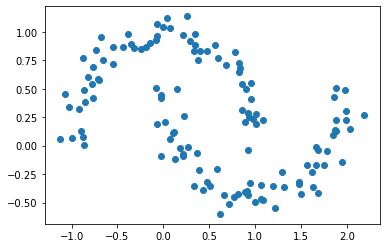

In [62]:
x, y = datasets.make_moons(128, noise=.1)
plt.scatter(x[:, 0], x[:, 1]);

### NICE (Non-linear Independent Component Estimation)

The NICE (Non-linear Independent Component Estimation; Dinh, et al. 2015) model is a predecessor of RealNVP. The transformation in NICE is the affine coupling layer without the scale term, known as additive coupling layer.

$$
\begin{cases}
    \mathbf{u}_{1:d} &= \mathbf{x}_{1:d} \\
    \mathbf{u}_{d+1:D} &= \mathbf{x}_{d+1:D} + \mu(\mathbf{x}_{1:d})
    \end{cases}
    \Leftrightarrow
    \begin{cases}
    \mathbf{x}_{1:d} &= \mathbf{u}_{1:d} \\
    \mathbf{x}_{d+1:D} &= \mathbf{u}_{d+1:D} - \mu(\mathbf{u}_{1:d})
\end{cases}
$$

In [63]:
import torch
import torch.optim as optim
import torch.nn.functional as F

from nflows.distributions.normal import StandardNormal
from nflows.flows.base import Flow
from nflows.nn import nets as nets
from nflows.transforms.base import CompositeTransform
from nflows.transforms.coupling import AdditiveCouplingTransform
from nflows.transforms.normalization import BatchNorm


class NICE(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            num_layers=2,
            num_blocks_per_layer=2,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        mask = torch.ones(features)
        mask[::2] = -1

        def create_resnet(in_features, out_features):
            return nets.ResidualNet(
                in_features,
                out_features,
                hidden_features=hidden_features,
                num_blocks=num_blocks_per_layer,
                activation=activation,
                dropout_probability=dropout_probability,
                use_batch_norm=batch_norm_within_layers,
            )

        layers = []
        for _ in range(num_layers):
            transform = AdditiveCouplingTransform(mask=mask, transform_net_create_fn=create_resnet)
            layers.append(transform)
            mask *= -1
            if batch_norm_between_layers:
                layers.append(BatchNorm(features=features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )


In [64]:
nice = NICE(features=2, hidden_features=4, num_layers=2, num_blocks_per_layer=2)
nice_opt = optim.Adam(nice.parameters())

In [65]:
def train(model, opt, num_iter=5000, iter_log=5000):
    for i in range(num_iter):
        x, y = datasets.make_moons(128, noise=.1)
        x = torch.tensor(x, dtype=torch.float32)
        opt.zero_grad()
        loss = -model.log_prob(inputs=x).mean()
        loss.backward()
        opt.step()

        if (i + 1) % iter_log == 0:
            xline = torch.linspace(-1.5, 2.5, 100)
            yline = torch.linspace(-.75, 1.25, 100)
            xgrid, ygrid = torch.meshgrid(xline, yline)
            xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

            with torch.no_grad():
                zgrid = model.log_prob(xyinput).exp().reshape(100, 100)

            plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
            plt.title('iteration {}'.format(i + 1))
            plt.show()

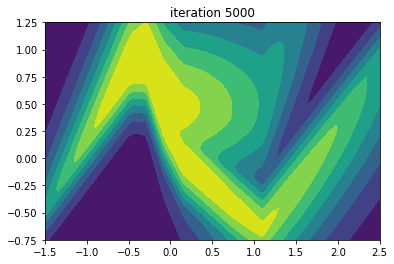

In [66]:
train(nice, nice_opt)

### RealNVP

$$
\begin{cases}
    \mathbf{u}_{1:d} &= \mathbf{x}_{1:d} \\
    \mathbf{u}_{d+1:D} &= \mathbf{x}_{d+1:D} \odot \exp{(\sigma{(\mathbf{x}_{1:d})})} + \mu(\mathbf{x}_{1:d})
    \end{cases}
    \Leftrightarrow
    \begin{cases}
    \mathbf{x}_{1:d} &= \mathbf{u}_{1:d} \\
    \mathbf{x}_{d+1:D} &= (\mathbf{u}_{d+1:D} - \mu(\mathbf{u}_{1:d})) \odot \exp{(-\sigma{(\mathbf{u}_{1:d})})}
\end{cases}
$$


In [67]:
from nflows.transforms import AffineCouplingTransform


class RealNVP(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            num_layers=2,
            num_blocks_per_layer=2,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        mask = torch.ones(features)
        mask[::2] = -1

        def create_resnet(in_features, out_features):
            return nets.ResidualNet(
                in_features,
                out_features,
                hidden_features=hidden_features,
                num_blocks=num_blocks_per_layer,
                activation=activation,
                dropout_probability=dropout_probability,
                use_batch_norm=batch_norm_within_layers,
            )

        layers = []
        for _ in range(num_layers):
            transform = AffineCouplingTransform(mask=mask, transform_net_create_fn=create_resnet)
            layers.append(transform)
            mask *= -1
            if batch_norm_between_layers:
                layers.append(BatchNorm(features=features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )

In [68]:
real_nvp = RealNVP(features=2, hidden_features=4, num_layers=2, num_blocks_per_layer=2)
real_nvp_opt = optim.Adam(real_nvp.parameters())

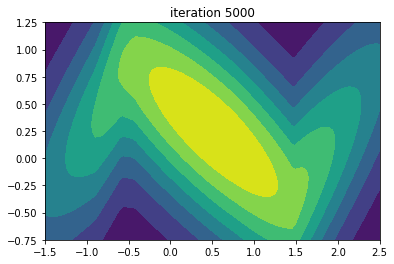

In [69]:
train(real_nvp, real_nvp_opt)

### Masked Autoregressive Flow (MAF)

In [70]:
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import RandomPermutation, ReversePermutation


class MaskedAutoregressiveFlow(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            num_layers=2,
            num_blocks_per_layer=2,
            use_residual_blocks=True,
            use_random_masks=False,
            use_random_permutations=False,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        if use_random_permutations:
            permutation_constructor = RandomPermutation
        else:
            permutation_constructor = ReversePermutation

        layers = []
        for _ in range(num_layers):
            layers.append(permutation_constructor(features))
            layers.append(
                MaskedAffineAutoregressiveTransform(
                    features=features,
                    hidden_features=hidden_features,
                    num_blocks=num_blocks_per_layer,
                    use_residual_blocks=use_residual_blocks,
                    random_mask=use_random_masks,
                    activation=activation,
                    dropout_probability=dropout_probability,
                    use_batch_norm=batch_norm_within_layers,
                )
            )
            if batch_norm_between_layers:
                layers.append(BatchNorm(features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )


In [71]:
maf = MaskedAutoregressiveFlow(features=2, hidden_features=4)
maf_opt = optim.Adam(maf.parameters())

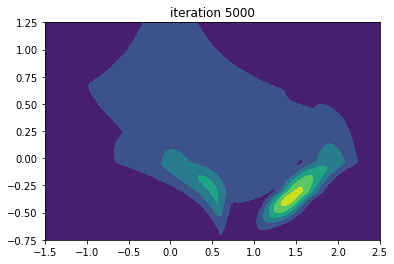

In [72]:
train(maf, maf_opt)

### Conditional NICE

$$
\begin{cases}
    \mathbf{u}_{1:d} &= \mathbf{x}_{1:d} \\
    \mathbf{u}_{d+1:D} &= \mathbf{x}_{d+1:D} + \mu(\mathbf{x}_{1:d}, \mathbf{c})
    \end{cases}
    \Leftrightarrow
    \begin{cases}
    \mathbf{x}_{1:d} &= \mathbf{u}_{1:d} \\
    \mathbf{x}_{d+1:D} &= \mathbf{u}_{d+1:D} - \mu(\mathbf{u}_{1:d}, \mathbf{c})
\end{cases}
$$

In [73]:
import torch
import torch.optim as optim
import torch.nn.functional as F

from nflows.distributions.normal import StandardNormal
from nflows.flows.base import Flow
from nflows.nn import nets as nets
from nflows.transforms.base import CompositeTransform
from nflows.transforms.coupling import AdditiveCouplingTransform
from nflows.transforms.normalization import BatchNorm


class cNICE(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            context_features,
            num_layers=2,
            num_blocks_per_layer=2,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        mask = torch.ones(features)
        mask[::2] = -1

        def create_resnet(in_features, out_features):
            return nets.ResidualNet(
                in_features,
                out_features,
                hidden_features=hidden_features,
                context_features=context_features,
                num_blocks=num_blocks_per_layer,
                activation=activation,
                dropout_probability=dropout_probability,
                use_batch_norm=batch_norm_within_layers,
            )

        layers = []
        for _ in range(num_layers):
            transform = AdditiveCouplingTransform(mask=mask, transform_net_create_fn=create_resnet)
            layers.append(transform)
            mask *= -1
            if batch_norm_between_layers:
                layers.append(BatchNorm(features=features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )


In [74]:
c_nice = cNICE(features=2, hidden_features=4, context_features=1)
c_nice_opt = optim.Adam(c_nice.parameters())

In [75]:
def train_conditional(model, opt, num_iter=5000, iter_log=5000):
    for i in range(num_iter):
        x, y = datasets.make_moons(128, noise=.1)
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
        opt.zero_grad()
        loss = -model.log_prob(inputs=x, context=y).mean()
        loss.backward()
        opt.step()

        if (i + 1) % iter_log == 0:
            fig, ax = plt.subplots(1, 2, figsize=(12, 8))
            xline = torch.linspace(-1.5, 2.5, 100)
            yline = torch.linspace(-.75, 1.25, 100)
            xgrid, ygrid = torch.meshgrid(xline, yline)
            xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

            with torch.no_grad():
                zgrid0 = model.log_prob(xyinput, torch.zeros(10000, 1)).exp().reshape(100, 100)
                zgrid1 = model.log_prob(xyinput, torch.ones(10000, 1)).exp().reshape(100, 100)

            ax[0].contourf(xgrid.numpy(), ygrid.numpy(), zgrid0.numpy())
            ax[1].contourf(xgrid.numpy(), ygrid.numpy(), zgrid1.numpy())
            fig.suptitle('iteration {}'.format(i + 1))
            plt.show()

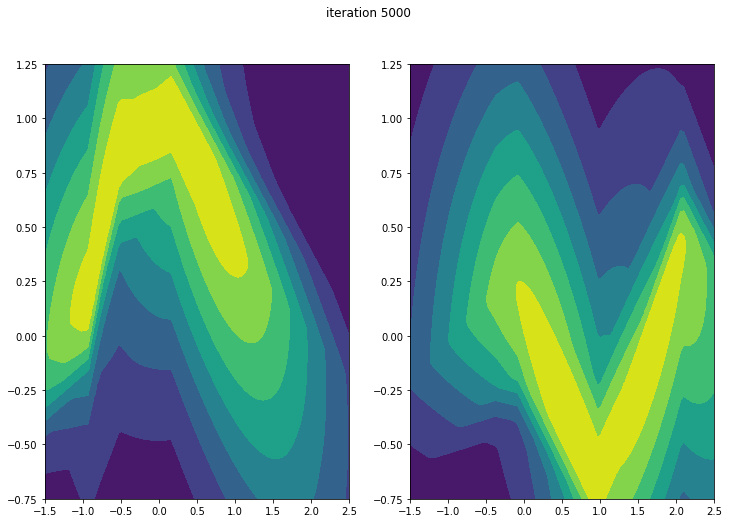

In [76]:
train_conditional(c_nice, c_nice_opt)

### Conditional RealNVP

$$
\begin{cases}
    \mathbf{u}_{1:d} &= \mathbf{x}_{1:d} \\
    \mathbf{u}_{d+1:D} &= \mathbf{x}_{d+1:D} \odot \exp{(\sigma{(\mathbf{x}_{1:d}, \mathbf{c})})} + \mu(\mathbf{x}_{1:d}, \mathbf{c})
    \end{cases}
    \Leftrightarrow
    \begin{cases}
    \mathbf{x}_{1:d} &= \mathbf{u}_{1:d} \\
    \mathbf{x}_{d+1:D} &= (\mathbf{u}_{d+1:D} - \mu(\mathbf{u}_{1:d}, \mathbf{c})) \odot \exp{(-\sigma{(\mathbf{u}_{1:d}, \mathbf{c}))}}
\end{cases}
$$

In [77]:
class cRealNVP(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            context_features,
            num_layers=2,
            num_blocks_per_layer=2,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        mask = torch.ones(features)
        mask[::2] = -1

        def create_resnet(in_features, out_features):
            return nets.ResidualNet(
                in_features,
                out_features,
                hidden_features=hidden_features,
                context_features=context_features,
                num_blocks=num_blocks_per_layer,
                activation=activation,
                dropout_probability=dropout_probability,
                use_batch_norm=batch_norm_within_layers,
            )

        layers = []
        for _ in range(num_layers):
            transform = AffineCouplingTransform(mask=mask, transform_net_create_fn=create_resnet)
            layers.append(transform)
            mask *= -1
            if batch_norm_between_layers:
                layers.append(BatchNorm(features=features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )

In [78]:
c_real_nvp = cRealNVP(features=2, hidden_features=4, context_features=1)
c_real_nvp_opt = optim.Adam(c_real_nvp.parameters())

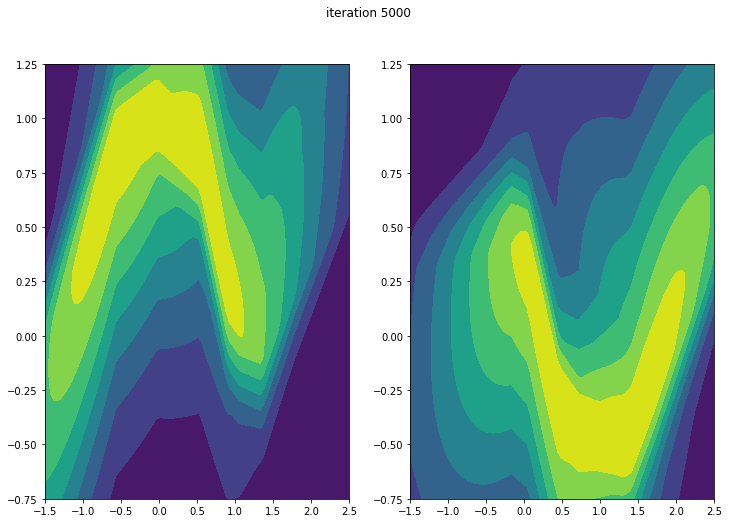

In [79]:
train_conditional(c_real_nvp, c_real_nvp_opt)

### Conditional Masked Autoregressive Flow (MAF)

In [80]:
class cMaskedAutoregressiveFlow(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            context_features,
            num_layers=2,
            num_blocks_per_layer=2,
            use_residual_blocks=True,
            use_random_masks=False,
            use_random_permutations=False,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        if use_random_permutations:
            permutation_constructor = RandomPermutation
        else:
            permutation_constructor = ReversePermutation

        layers = []
        for _ in range(num_layers):
            layers.append(permutation_constructor(features))
            layers.append(
                MaskedAffineAutoregressiveTransform(
                    features=features,
                    hidden_features=hidden_features,
                    context_features=context_features,
                    num_blocks=num_blocks_per_layer,
                    use_residual_blocks=use_residual_blocks,
                    random_mask=use_random_masks,
                    activation=activation,
                    dropout_probability=dropout_probability,
                    use_batch_norm=batch_norm_within_layers,
                )
            )
            if batch_norm_between_layers:
                layers.append(BatchNorm(features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )


In [81]:
c_maf = cMaskedAutoregressiveFlow(features=2, hidden_features=4, context_features=1)
c_maf_opt = optim.Adam(c_maf.parameters())

In [ ]:
train_conditional(c_maf, c_maf_opt)

## Metoda Flow Plugin Network (FPN)

### Koncepcja Plugin Network

![Plugin Network](figures/plugin_koperski.png)

Pomysł:
 - Rozszerzenie istniejącej sieci neuronowej bez dodatkowego treningu, np. gdy pojawią się dane z dodatkową informację (eng. partial evidence)

Założenia koncepcji:
 - Nie przetrenowujemy oryginalnej sieci lecz jedynie trenujmy komponent plugin
 - Czas predykcji modelu jest jedynie nieznacznie większy

### Koncepcja Flow Plugin Network

![](figures/schema-general.png)

Pomysł:
 - Rozszerzenie Plugin Networku do modeli generatywnych

## Wykorzystanie metody FPN do warunkowego generowania obrazów

* Kod do wytrenowania prostego VAE
* Wygenerowanie losowych obiektów
* Kod do wytrenowania prostego FPNa
* Wygenerowanie pożądanych obiektów

### Inne metody

  * PluGeN
  * StyleFlow

#TODO: Dodać po obrazku z przykładem i krótki opis

## Wykorzystanie metody FPN do warunkowego generowania chmur punktów

 * Zadanie: Wytrenować na podstawie powyższego kodu model do generowania chmur punktów
 * TODO: Dostarczyć PointFlowa (?)

## Bibliografia

[Normalizing Flows]()
[Flow based deep generative models](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html#nice)
[NICE]()
[RealNVP]()
[MAF]()
[Flow Plugin Network]()
